In [1]:
from graphviz import Source

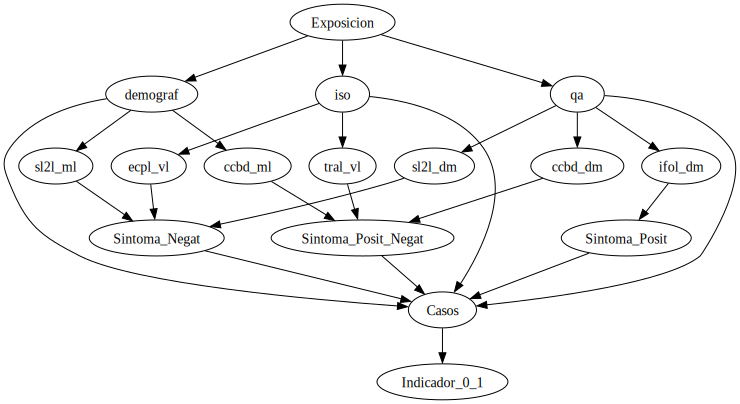

In [53]:
#Opcion 1
s = 'digraph {\
    qa;\
    demograf;\
    iso;\
    ecpl_vl;\
    ccbd_ml;\
    ccbd_dm;\
    sl2l_dm;\
    sl2l_ml;\
    tral_vl;\
    Casos;\
    Indicador_0_1;\
    Exposicion -> demograf -> Casos;\
    demograf -> ccbd_ml -> Sintoma_Posit_Negat ;\
    demograf -> sl2l_ml -> Sintoma_Negat;\
    Exposicion -> qa -> Casos;\
    qa -> ifol_dm -> Sintoma_Posit -> Casos ;\
    qa -> ccbd_dm  -> Sintoma_Posit_Negat;\
    qa -> sl2l_dm  -> Sintoma_Negat;\
    Exposicion -> iso -> Casos;\
    iso -> tral_vl -> Sintoma_Posit_Negat -> Casos;\
    iso -> ecpl_vl -> Sintoma_Negat -> Casos -> Indicador_0_1 ;\
        }'
dot = Source(s)
dot

In [1]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd

DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

def load_data_demo(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_demog.csv")
    return pd.read_csv(csv_path)

In [82]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [26]:
# Cargar DataFrame de UCLA 
df = load_data_prep()
df_dem = load_data_demo()
df1 = df.merge(df_dem, on="cod", how="left")

In [27]:
df1 = pd.get_dummies(df1, columns=['gender'])

In [4]:
# Especificar las variables cofunders, predictoras/cov y la variable target
cofounder_qa = ['ccbd_qa', 'ifol_qa','sl2l_qa'] 
cofounder_iso = ['tral_iso','ecpl_iso']
cofounder_demog = ['age','gender_F','gender_M']
cov_qa = ['sl2l_diameter', 'ccbd_diameter', 'ifol_diameter']
cov_iso = ['ecpl_volume', 'tral_volume']
cov_demog = ['sl2l_mean_length', 'ccbd_mean_length' ]
outcome = 'label'

In [5]:
df_demog = df1[cofounder_demog + cov_demog]
df_iso = df1[ cov_iso + cofounder_iso]
df_qa = df1[ cov_qa + cofounder_qa]

Pienso: obtener para cada confusora y grupo de variables afectadas una clasificación binaria.
Para lograr esto, utilizaré ML

In [83]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [7]:
std_scale_demog = StandardScaler() # Creamos el estandarizador para usarlo posteriormente
std_scale_iso = StandardScaler() # Creamos el estandarizador para usarlo posteriormente
std_scale_qa = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

std_scale_demog.fit(df_demog)
std_scale_iso.fit(df_iso)
std_scale_qa.fit(df_qa)

df_demog_scaled = std_scale_demog.transform(df_demog)
df_iso_scaled = std_scale_iso.transform(df_iso)
df_qa_scaled = std_scale_qa.transform(df_qa)

In [25]:
#elijo el número de clusters
k = 2
kmeans_dmg = KMeans(n_clusters=k, n_init=1, random_state=1)
kmeans_iso = KMeans(n_clusters=k, n_init=1, random_state=1)
kmeans_qa = KMeans(n_clusters=k, n_init=1, random_state=1)

kmeans_dmg.fit(df_demog_scaled)
kmeans_iso.fit(df_iso_scaled)
kmeans_qa.fit(df_qa_scaled)

KMeans(n_clusters=2, n_init=1, random_state=1)

In [9]:
kmeans_dmg.inertia_, kmeans_dmg.score(df_demog_scaled)

(279.6723048862823, -279.6723048862823)

In [10]:
y_pred_dmg = kmeans_dmg.predict(df_demog_scaled)
y_pred_iso = kmeans_iso.predict(df_iso_scaled)
y_pred_qa = kmeans_qa.predict(df_qa_scaled)

(y_pred_dmg == kmeans_dmg.labels_).all(), (y_pred_iso == kmeans_iso.labels_).all(), (y_pred_qa == kmeans_qa.labels_).all()

(True, True, True)

In [13]:
unique1, counts1 = np.unique(y_pred_dmg, return_counts=True)
dict(zip(unique1, counts1))

{0: 33, 1: 63}

In [14]:
unique2, counts2 = np.unique(y_pred_iso, return_counts=True)
dict(zip(unique2, counts2))

{0: 44, 1: 52}

In [15]:
unique3, counts3 = np.unique(y_pred_qa, return_counts=True)
dict(zip(unique3, counts3))

{0: 34, 1: 62}

In [28]:
df1.columns

Index(['cod', 'afsl_ad', 'afsl_area_of_end_region_1',
       'afsl_area_of_end_region_2', 'afsl_branch_volume', 'afsl_curl',
       'afsl_diameter', 'afsl_dti_fa', 'afsl_elongation', 'afsl_irregularity',
       ...
       'ufsr_span', 'ufsr_total_area_of_end_regions',
       'ufsr_total_radius_of_end_regions', 'ufsr_total_surface_area',
       'ufsr_trunk_volume', 'ufsr_volume', 'label', 'age', 'gender_F',
       'gender_M'],
      dtype='object', length=440)

In [56]:
df1 =pd.concat([df1.assign(dmg_group=0)[y_pred_dmg==0], df1.assign(dmg_group=1)[y_pred_dmg==1]])
df1 = pd.concat([df1.assign(iso_group=0)[y_pred_iso==0], df1.assign(iso_group=1)[y_pred_iso==1]])
df1 = pd.concat([df1.assign(qa_group=0)[y_pred_qa==0], df1.assign(qa_group=1)[y_pred_qa==1]])
df1 = df1.sort_index()

In [60]:
df2 = df1[['dmg_group', 'iso_group', 'qa_group', 'label']]


In [68]:
df2

,dmg_group,iso_group,qa_group,label
0,1,0,1,1
1,1,1,0,1
2,1,0,0,1
3,0,1,1,1
4,1,1,0,1
...,...,...,...,...
91,1,0,1,0
92,1,1,1,0
93,1,0,1,0
94,1,1,1,0


In [73]:
df2.groupby(['dmg_group', 'iso_group', 'qa_group', 'label']).size()


dmg_group  iso_group  qa_group  label
0          0          0         0         2
                                1         5
                      1         0         2
                                1         7
           1          0         0         3
                                1         3
                      1         0         4
                                1         7
1          0          0         0         6
                                1         6
                      1         0         7
                                1         9
           1          0         0         4
                                1         5
                      1         0        18
                                1         8
dtype: int64

In [88]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [89]:
# Regresión logística para predecir 'label' en función de los predictores
X = df2.drop(['label'], axis=1)
y = df2['label']
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000)

validation_size = 0.20
seed = 42
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
model.fit(X, y)


LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   solver='saga')

Forma 1

Forma 2


In [90]:
name='Logistic Regression'
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

Logistic Regression: 0.546429 (0.159959)


In [91]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))

0.55


In [92]:
print(confusion_matrix(Y_validation, predictions))

[[4 5]
 [4 7]]


In [93]:
# Informe de clasificación
print("Informe de Clasificación:")
print(classification_report(Y_validation, predictions))

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.58      0.64      0.61        11

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.55      0.55      0.55        20



In [94]:
from sklearn.manifold import TSNE
tsne_dmg = TSNE(n_components=2, random_state=42)
tsne_iso = TSNE(n_components=2, random_state=42)
tsne_qa = TSNE(n_components=2, random_state=42)
X_reduced_tsne_dmg = tsne_dmg.fit_transform(df_demog_scaled)


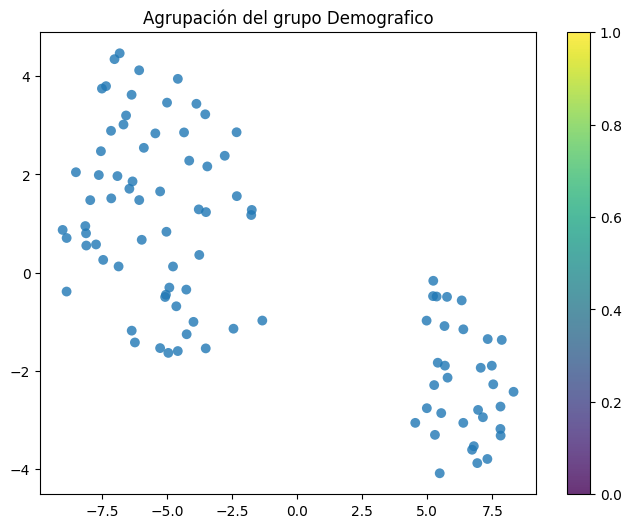

In [95]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scat = ax.scatter(*X_reduced_tsne_dmg.T, s=50,  
                  edgecolors='None', alpha=0.8)
plt.title('Agrupación del grupo Demografico')
fig.colorbar(scat)